## BME i9400
## Fall 2024
### Applications of Machine Learning to BME
#### Convolutional Neural Networks in EEG classification

## Review of the previous lecture
- Convolutional neural networks employ *weight sharing* by sliding *filters* across the input data
- Can be 1D, 2D, or 3D depending on the data
- Typically employ *pooling* operations to progressively reduce the size of the features

### 1D Convolution
<img src="conv1d.jpeg" alt="1D Convolution" width="1200"/>


### 2D Convolution
<img src="conv2d.jpeg" alt="2D Convolution" width="1200"/>


### A Typical CNN
<img src="conv.png" alt="ANN Diagram" width="1200"/>

## Demonstrating convolutional neural networks for EEG classification
- CNNs are often used in biomedical applications due to their ability to learn spatial and temporal patterns in data
- An example of a spatiotemporal dataset is the electroencephalogram (EEG), which records electrical activity in the brain over time


## What is EEG?
- EEG is a non-invasive brain imaging technique that records the brain's natural electrical activity
- Electrodes are placed on the scalp and capture small voltages that fluctuate over time
    - These fluctuations carry information about the state of the brain

<img src="eeg.webp" alt="ANN Diagram" width="1200"/>

## The EEG can be represented as a 2D matrix (image)
- Each electrode on the scalp records a time series of electrical activity
- Collectively, these time series form a 2D matrix, where one dimension represents the electrodes and the other dimension represents the time points
    - The rows of the matrix represent the electrodes
    - The columns of the matrix represent the time points
- As a result, we can apply convolutional layers to capture spatial and temporal patterns in the EEG data
    - Note however that the nature of rows (electrodes) and columns (samples) are different from images, where both rows and columns correspond to pixels

## EEG dataset
- The dataset that we will be working with is available on [Kaggle](https://www.kaggle.com/datasets/nnair25/Alcoholics/data)
- This dataset arises from a research study that examines EEG correlates of genetic predisposition to alcoholism
- Each example consists of data measured at 64 scalp electrodes, with the voltages collected for 1 sec with a 256 Hz sampling rate
- Subjects have been divided into two groups: alcoholic and control
- Subjects were shown pictures of objects from a picture set, either a single stimulus or two stimuli in a matched or non-matched condition
- The primary purpose of the stimuli is to elicit brain activity from subjects in a reproducible condition

## Objective of the CNN
- The objective of the model that we will build is to discriminate the brain activity of alcoholics from that of control subjects
- The information that discriminates subjects may either be represented as patterns across *space* (across electrodes) or across *time* (across time points)
- Therefore, we would like our model to be able to capture both spatial and temporal patterns in the EEG data
- We will therefore use an initial spatial convolutional layer followed by a temporal convolutional layer
- Finally, we will use a dense layer to classify the data

## Import necessary libraries

In [2]:
import torch
import torch.nn as nn
from numpy.ma.core import shape
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

ModuleNotFoundError: No module named 'torch'

## Loading the dataset
- The dataset has been preprocessed and stored in a numpy file
    - The code for generating the dataset is provided at the end of this notebook
- The data is stored in a dictionary with keys `X` and `y`

In [66]:
tmp = np.load('eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {y.shape}")
print(f"The number of features is {X.shape[1]*X.shape[2]}")

The shape of X is (468, 64, 256)
The shape of y is (468,)
The number of features is 16384


## Examining the data
- Let's look at a few examples from the dataset
- We will visualize the space-time matrix of EEG

In [ ]:
trial_index = -1

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(X[trial_index], aspect='auto', cmap='jet')
ax[0].set_xlabel('Time samples')
ax[0].set_ylabel('Electrodes')

ax[1].plot(X[trial_index,::4,:].T)
ax[1].set_xlabel('Time samples')
ax[1].set_ylabel('Voltage')

## Data preprocessing and splitting
- As we will be working with PyTorch, we need to convert our native Numpy data to PyTorch tensor format
- We will also split the data into training and testing sets

In [ ]:
# Ensure X is a numpy array of float32
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)

# Ensure y is a numpy array of integers
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((374, 64, 256), (374,), (94, 64, 256), (94,))

In [68]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [43]:
## create a random tensor input to pass into a conv2d layer
batch_size = 16
n_channels = 64
n_samples = 256

# create random input
random_input = torch.randn(size=(batch_size,1,n_channels,n_samples))
random_input.shape

torch.Size([16, 1, 64, 256])

In [44]:
## create our SPATIAL convolutional layer 
print(f"The input into our spatial convolution layer is {random_input.shape}")
spatial_conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(n_channels, 1))  # Spatial filtering
random_output = spatial_conv(random_input)
print(f"The output of our spatial convolution layer is {random_output.shape}")

The input into our spatial convolution layer is torch.Size([16, 1, 64, 256])
The output of our spatial convolution layer is torch.Size([16, 2, 1, 256])


In [45]:
## create our TEMPORAL convolutional layer
random_input = random_output
print(f"The input into our temporal convolution layer is {random_input.shape}")
temporal_conv = nn.Conv2d(in_channels = 2, out_channels = 6, kernel_size=(1, 10), padding = 'same', groups=2)
random_output = temporal_conv(random_input)
print(f"The output of our temporal convolution layer is {random_output.shape}")

The input into our temporal convolution layer is torch.Size([16, 2, 1, 256])
The output of our temporal convolution layer is torch.Size([16, 6, 1, 256])


In [46]:
flatten = nn.Flatten()
flattened_output = flatten(random_output)
print(f"The output of our flattened layer is {flattened_output.shape}")

The output of our flattened layer is torch.Size([16, 1536])


In [47]:
fc = nn.Linear(1536, 2)  # Dense layer
softmax = nn.Softmax(dim=1)
fc_output = fc(flattened_output)
softmax_output = softmax(fc_output)
print(f"The output of our fully connected layer output is {fc_output.shape}")
print(f"The output of our softmax output is {softmax_output.shape}")

The output of our fully connected layer output is torch.Size([16, 2])
The output of our softmax output is torch.Size([16, 2])


In [48]:
softmax_output

tensor([[0.6255, 0.3745],
        [0.5478, 0.4522],
        [0.5793, 0.4207],
        [0.6076, 0.3924],
        [0.5432, 0.4568],
        [0.5896, 0.4104],
        [0.5605, 0.4395],
        [0.5062, 0.4938],
        [0.5078, 0.4922],
        [0.6194, 0.3806],
        [0.4826, 0.5174],
        [0.6174, 0.3826],
        [0.5088, 0.4912],
        [0.5516, 0.4484],
        [0.6237, 0.3763],
        [0.5754, 0.4246]], grad_fn=<SoftmaxBackward0>)

## Defining the model architecture
- We will define a simple CNN model with two convolutional layers and a dense layer
- The first convolutional layer will be spatial, filtering across the electrodes
    - The kernel here will have a size of (64, 1)
    - We will learn 16 such filters (each filter will be applied to all electrodes but capture different spatial patterns)
- The second convolutional layer will be temporal, filtering across the time points
    - Note that these temporal filters will now be applied on top of the spatially filtered data!
    - The kernel here will have a size of (1, 10) with a stride of 2 (our filter has a length of 10 samples and we will slide it by 2 samples at a time)
- We then flatten the output of the second convolutional layer to create a single long vector
- Finally, we pass this vector through a dense layer that has 2 outputs, one for each class
- We will use the softmax activation function to convert the output of the dense layer to probabilities

In [75]:
# Define the CNN model
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), num_classes)  # Dense layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)

        return x

## Instantiating the model
- Although we have defined the architecture, we have not yet instantiated the model
- We will do so now by telling the model how many input channels, time points, and classes it should expect

In [76]:
# Initialize the model
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
input_channels, input_timepoints

(64, 256)

In [77]:
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)
print(model)

EEGCNN(
  (spatial_conv): Conv2d(1, 8, kernel_size=(64, 1), stride=(1, 1))
  (temporal_conv): Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1984, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


## PyTorch dataloaders
- To train the model, we need to create *data loaders* that will feed the data to the model in batches
- We will use the `TensorDataset` and `DataLoader` classes from PyTorch to create these data loaders

In [78]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining the loss function and optimizer
- As usual, we will use the cross-entropy loss function and the Adam optimizer
- Remember that the Adam optimizer is a variant of stochastic gradient descent that is often used in deep learning

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Let's train the model!
- We will train the model for 10 epochs (that is, we will pass through the entire training set 10 times in batches of 32)

In [80]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.7194
Epoch 2/10, Loss: 0.5880
Epoch 3/10, Loss: 0.5354
Epoch 4/10, Loss: 0.4943
Epoch 5/10, Loss: 0.4510
Epoch 6/10, Loss: 0.4275
Epoch 7/10, Loss: 0.4095
Epoch 8/10, Loss: 0.3861
Epoch 9/10, Loss: 0.3857
Epoch 10/10, Loss: 0.3732


## Let's evaluate the model
- We first will pass through the test set and calculate the accuracy of the model

In [58]:
# Evaluate the model
model.eval()
correct = 0
total = 0

all_outputs = []
all_labels = []

for X_batch, y_batch in test_loader:
    outputs = model(X_batch)
    break
    
outputs[0:5], torch.max(outputs[0:5], 1), y_batch[0:5]

(tensor([[7.7867e-01, 2.2133e-01],
         [3.7714e-04, 9.9962e-01],
         [4.3944e-03, 9.9561e-01],
         [7.2259e-03, 9.9277e-01],
         [1.3046e-04, 9.9987e-01]], grad_fn=<SliceBackward0>),
 torch.return_types.max(
 values=tensor([0.7787, 0.9996, 0.9956, 0.9928, 0.9999], grad_fn=<MaxBackward0>),
 indices=tensor([0, 1, 1, 1, 1])),
 tensor([1, 1, 1, 0, 1]))

In [81]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_outputs.append(outputs)
        all_labels.append(y_batch)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 76.60%


## How did we do relative to chance?

## Let's plot the ROC curve
- We will need to assemble all predictions and labels on the test set
- We will need to convert the PyTorch tensors to numpy arrays so that we can use the `roc_curve` and `auc` functions from `sklearn.metrics`

In [82]:
py_hat = torch.cat(all_outputs, dim=0)
y_test = torch.cat(all_labels, dim=0)

# cast to numpy
py_hat = py_hat.numpy()
y_test = y_test.numpy()

## We are now ready to plot the ROC curve

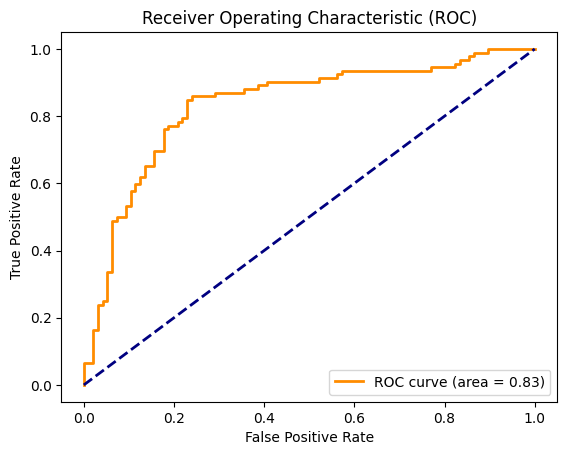

In [83]:
fpr, tpr, _ = roc_curve(y_test, py_hat[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Code for generating dataset below

In [ ]:
import kagglehub
import glob
from tqdm import tqdm

def load_and_package_data():

    path = kagglehub.dataset_download("nnair25/Alcoholics")
    print("Path to dataset files:", path)

    ##
    _dfs_list = []
    for csv_filename in tqdm(glob.glob(path+'/SMNI_CMI_TRAIN/*.csv')):
        _dfs_list.append(pd.read_csv(csv_filename))
    df = pd.concat(_dfs_list)
    del(_dfs_list)
    df = df.drop(['Unnamed: 0'], axis=1)

    ##
    channel_list = list(set(df['sensor position']))
    channel_list.sort()

    channel_mapping = {
        'AFZ':'AFz',
        'CPZ':'CPz',
        'CZ':'Cz',
        'FCZ':'FCz',
        'FP1':'Fp1',
        'FP2':'Fp2',
        'FPZ':'Fpz',
        'FZ':'Fz',
        'OZ':'Oz',
        'POZ':'POz',
        'PZ':'Pz',
    }

    channel_mapping_full = dict()

    for ch in channel_list:
        if ch in channel_mapping:
            channel_mapping_full[ch] = channel_mapping[ch]
        else:
            channel_mapping_full[ch] = ch

    channel_list_fixed = [channel_mapping_full[ch] for ch in channel_list]

    df['sensor position'] = df['sensor position'].map(channel_mapping_full)

    # transpose the table to make the data extraction easier
    transposed_df_list = []

    for group_df in tqdm(df.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
        _df = pd.DataFrame(group_df[1]['sensor value']).T
        _df.columns = [f'sample_{idx}' for idx in range(256)]
        _df['name'] = group_df[0][0]
        _df['trial number'] = group_df[0][1]
        _df['matching condition'] = group_df[0][2]
        _df['sensor position'] = group_df[0][3]
        _df['subject identifier'] = group_df[0][4]

        transposed_df_list.append(_df)

    df = pd.concat(transposed_df_list)
    df = df[[*df.columns[-5:],*df.columns[0:-5]]]
    df = df.reset_index(drop=True)
    df.head(3)

    def get_record_df(df, name, trial_number, matching_condition, channel_list):
        df_record = df[df['name'].eq(name) & df['trial number'].eq(trial_number) & df['matching condition'].eq(matching_condition)].set_index(['sensor position']).loc[channel_list]
        return df_record

    def get_signal_array(df, name, trial_number, matching_condition, channel_list):
        df_record = get_record_df(df, name, trial_number, matching_condition, channel_list)
        return df_record.to_numpy()[:, 4:]

    all_signal_arrays = []
    all_subject_ids = []
    for name in df['name'].unique():
        for trial_number in df[df['name'].eq(name)]['trial number'].unique():
            for matching_condition in df[df['name'].eq(name) & df['trial number'].eq(trial_number)]['matching condition'].unique():
                signal_array = get_signal_array(df, name, trial_number, matching_condition, channel_list_fixed)
                all_signal_arrays.append(signal_array)
                id = df[(df['name'].eq(name)) & (df['trial number'].eq(trial_number)) & (df['matching condition'].eq(matching_condition))]['subject identifier'].values[0]
                all_subject_ids.append(id)

    X = np.array(all_signal_arrays)
    all_subject_ids_binary = [1 if id == 'a' else 0 for id in all_subject_ids]
    y = np.array(all_subject_ids_binary)

    return X, y